In [1]:
import time
start = time.time()

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from scipy.misc import imresize 
from skimage.morphology import label
from PIL import Image

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

%matplotlib inline

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# First, we work on the train-test-samples from my (https://www.kaggle.com/kjeanclaude/download-train-test-samples-for-local-prototype) kernel. 
# We could generalize later on the whole competition dataset.

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#print(os.listdir("../input/"))
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 77
random.seed = seed
np.random.seed = seed
print('Done!')

print("tf.__version__ : ", tf.__version__)
print("python --version : ", sys.version)
print("numpy --version : ", np.__version__)
PyVersion = sys.version

Done!
tf.__version__ :  1.7.0
python --version :  3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
numpy --version :  1.14.2


In [4]:
!os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/bin/sh: 1: os.environ[TF_CPP_MIN_LOG_LEVEL]: not found


In [5]:
TRAIN_PATH = 'train_color1/'
LABEL_PATH = 'train_label1/'
TEST_PATH = 'test1/'

In [6]:

train_ids = next(os.walk(TRAIN_PATH))[2]
train_ids[:3]

['171206_034342293_Camera_5.jpg',
 '170927_063952977_Camera_6.jpg',
 '171206_032947724_Camera_5.jpg']

In [7]:
label_ids = next(os.walk(LABEL_PATH))[2] 
test_ids = next(os.walk(TEST_PATH))[2] 

In [8]:
test_ids[:3]

['5ba8325c2865dc6d167d0c42ef5c2dc3.jpg',
 'd7a1585fa55128c9591bd1756da82efd.jpg',
 '9b68545d2102e97e7ec8be28b062ef6f.jpg']

In [9]:
label_ids[:3]

['170908_075422059_Camera_5_instanceIds.png',
 '170908_061508524_Camera_5_instanceIds.png',
 '170908_081939831_Camera_6_instanceIds.png']

In [10]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [11]:
len(train_ids)

39222

In [12]:
features_im_path = []
#features_im_path.append(path) 
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm_notebook(enumerate(label_ids), total=len(label_ids)):
    path = LABEL_PATH + id_ 
    img = imread(path, as_grey=True) 
    img = np.reshape(np.array(img), (img.shape[0], img.shape[1])) # To transform as an numpy array first
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    img = imresize(img, (IMG_HEIGHT, IMG_WIDTH), mode='L', interp='nearest') 
    img = np.reshape(img,(img.shape[0], img.shape[1], 1)) 
    Y_train[n] = img 



Getting and resizing train images and masks ... 


HBox(children=(IntProgress(value=0, max=39222), HTML(value='')))

HBox(children=(IntProgress(value=0, max=39222), HTML(value='')))

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


In [13]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_a
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!') 

Getting and resizing test images ... 


HBox(children=(IntProgress(value=0, max=1917), HTML(value='')))

NameError: name 'id_a' is not defined

In [14]:
def display_samples(nb, train_ids):
    #imgs_ids = [c for c in category_to_product.keys() if category_id in str(c)]
    #ix = random.randint(0, len(train_ids))
    ix = random.randint(nb, len(train_ids)-1)
    print('ix value : ', ix)
    imgs_ids = [] 
    imgs_ids.append(X_train[ix]) 
    #imgs_ids.append(X_train[ix]) 
    
    ### For printing purposes, we should reshape it without the last channel
    Y_2 = np.reshape(Y_train[ix],(Y_train[ix].shape[0], Y_train[ix].shape[1])) 
    imgs_ids.append(Y_2) 
    
    print('len imgs_ids : ', len(imgs_ids))
    fig, axs = plt.subplots(1, len(imgs_ids), figsize=(10, 4))
    
    print('axs : ', axs)
    for i, ax_i in enumerate(axs):
        ax_i.imshow(imgs_ids[i])
        ax_i.set_title(i)
        ax_i.grid('off')
        ax_i.axis('off')
        
    #return imgs_ids

ix value :  25018
len imgs_ids :  2
axs :  [<matplotlib.axes._subplots.AxesSubplot object at 0x7f16bc75a978>


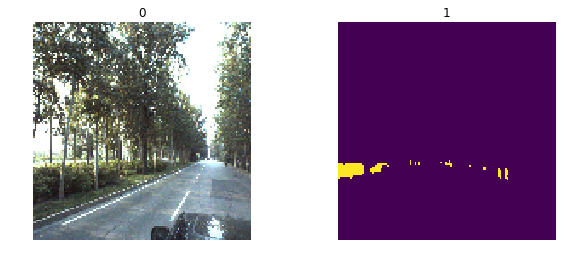

In [15]:
display_samples(0, train_ids) 
#len(img_ids)

In [16]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 7)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

In [17]:
def mean_iou_(y_pred,y_true):
    y_pred_ = tf.to_int64(y_pred > 0.5)
    y_true_ = tf.to_int64(y_true > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true_, y_pred_, 7)
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [18]:
# Build U-Net model 
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
#s = Lambda(lambda x: x) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs]) 
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=[mean_iou]) 
#model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy']) 
model.summary() 


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [19]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=4, epochs=8)
#deliberately stopped at 9th epoch and carried on with the model as it was taking lot of time 

Train on 31377 samples, validate on 7845 samples
Epoch 1/50
31377/31377 [==============================] - 1704s 54ms/step - loss: 0.0785 - mean_iou: 0.4908 - val_loss: 0.0755 - val_mean_iou: 0.4909
Epoch 2/50
31377/31377 [==============================] - 1688s 54ms/step - loss: 0.0740 - mean_iou: 0.4908 - val_loss: 0.0732 - val_mean_iou: 0.4909
Epoch 3/50
31377/31377 [==============================] - 1694s 54ms/step - loss: 0.0734 - mean_iou: 0.4909 - val_loss: 0.0737 - val_mean_iou: 0.4909
Epoch 4/50
31377/31377 [==============================] - 1683s 54ms/step - loss: 0.0732 - mean_iou: 0.4909 - val_loss: 0.0733 - val_mean_iou: 0.4909
Epoch 5/50
31377/31377 [==============================] - 1693s 54ms/step - loss: 0.0733 - mean_iou: 0.4909 - val_loss: 0.0732 - val_mean_iou: 0.4909
Epoch 6/50
31377/31377 [==============================] - 1684s 54ms/step - loss: 0.0732 - mean_iou: 0.4909 - val_loss: 0.0732 - val_mean_iou: 0.4909
Epoch 7/50
31377/31377 [===========================

KeyboardInterrupt: 

In [22]:
print('Predictions ... ')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.1)], verbose=1)

Predictions ... 
3922/3922 [==============================] - 59s 15ms/step


In [23]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)

In [24]:
def display_predictions(nb, preds_train_t):
    #imgs_ids = [c for c in category_to_product.keys() if category_id in str(c)]
    #ix = random.randint(0, len(train_ids))
    ix = random.randint(nb, len(preds_train_t)-1)
    print('ix value : ', ix)
    imgs_ids = [] 
    imgs_labels = []
    imgs_ids.append(X_train[ix]) 
    imgs_labels.append("Image")
    
    ### For printing purposes, we should reshape it without the last channel
    Y_2 = np.reshape(Y_train[ix],(Y_train[ix].shape[0], Y_train[ix].shape[1])) 
    imgs_ids.append(Y_2) 
    imgs_labels.append("Label")
    
    ## train preds
    tpreds = np.reshape(preds_train_t[ix],(preds_train_t[ix].shape[0], preds_train_t[ix].shape[1])) 
    imgs_ids.append(tpreds) 
    imgs_labels.append("Prediction")
    
    print('len imgs_ids : ', len(imgs_ids))
    fig, axs = plt.subplots(1, len(imgs_ids), figsize=(10, 4))
    
    print('axs : ', axs)
    for i, ax_i in enumerate(axs):
        ax_i.imshow(imgs_ids[i])
        ax_i.set_title(imgs_labels[i])
        ax_i.grid('off')
        ax_i.axis('off')

ix value :  1636
len imgs_ids :  3
axs :  [<matplotlib.axes._subplots.AxesSubplot object at 0x7f16a16959e8>


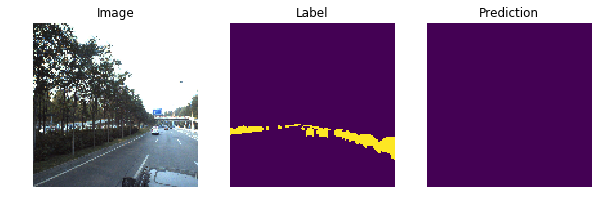

In [25]:
display_predictions(2, preds_train_t) 